In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
import pathlib

COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]
MAX_TRAIN_FORECASTS = 14

Using TensorFlow backend.


In [2]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")

In [3]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES

In [4]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")

In [5]:
def np_intersection_over_union(boxes_pred, boxes_true):

    x_min = np.hstack([boxes_pred[:, 0:1], boxes_true[:, 0:1]])
    y_min = np.hstack([boxes_pred[:, 1:2], boxes_true[:, 1:2]])
    x_max = np.hstack([boxes_pred[:, 2:3], boxes_true[:, 2:3]])
    y_max = np.hstack([boxes_pred[:, 3:], boxes_true[:, 3:]])

    x_min = np.max(x_min, axis=-1, keepdims=True)
    y_min = np.max(y_min, axis=-1, keepdims=True)
    x_max = np.min(x_max, axis=-1, keepdims=True)
    y_max = np.min(y_max, axis=-1, keepdims=True)

    zeros = np.zeros_like(x_max)

    x_inter = np.hstack([zeros, x_max - x_min])
    y_inter = np.hstack([zeros, y_max - y_min])

    x_inter = np.max(x_inter, axis=-1, keepdims=True)
    y_inter = np.max(y_inter, axis=-1, keepdims=True)
    inter_area = x_inter * y_inter
    
    area_pred = (np.max(np.hstack([zeros, boxes_pred[:, 2:3] - boxes_pred[:, 0:1]]), axis=-1, keepdims=True) * 
                 np.max(np.hstack([zeros, boxes_pred[:, 3:] - boxes_pred[:, 1:2]]), axis=-1, keepdims=True))
    area_true = (np.max(np.hstack([zeros, boxes_true[:, 2:3] - boxes_true[:, 0:1]]), axis=-1, keepdims=True) * 
                 np.max(np.hstack([zeros, boxes_true[:, 3:] - boxes_true[:, 1:2]]), axis=-1, keepdims=True))

    iou = inter_area / (area_pred + area_true - inter_area + np.finfo(float).eps)
    
    return iou

In [8]:
merge = votes.join(answers, on="itemId", rsuffix="_a") 
merge["iou"] = np_intersection_over_union(merge.iloc[:, 1:5].values, merge.iloc[:, 5:9].values)
scaler = 1000
iou_all = merge.iou.mean() * scaler ###
user_id_count_iou = merge.groupby("userId").iou.agg(["count", "mean"])
user_id_count_iou[ "mean"] *= scaler

In [7]:
def find_center(y):
    center_x = (y[0, 2] + y[0, 0]) / 2
    center_y = (y[0, 3] + y[0, 1]) / 2 
    return np.array([center_x, center_y, center_x, center_y])


def scale(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    err_x, err_y = np.random.random(2)  
    
    err_x = 1 + (2 * err_x - 1) * err
    err_y = 1 + (2 * err_y - 1) * err
    
    err = np.array([err_x, err_y, err_x, err_y])
    
    return (x * np.reshape(err, (1, 1, 4)) + np.reshape(center, (1, 1, 4)), 
            y * np.reshape(err, (1, 4)) + np.reshape(center, (1, 4)))
    

def move(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    size_x = (y[0, 2] - y[0, 0]) / 2
    size_y = (y[0, 3] - y[0, 1]) / 2
    
    err_cx, err_cy = np.random.random(2)  
    
    err_cx = (2 * size_x * err_cx - size_x) * err
    err_cy = (2 * size_y * err_cy - size_y) * err
    
    err = np.array([err_cx, err_cy, err_cx, err_cy])
    
    return x + np.reshape(err + center, (1, 1, 4)), y + np.reshape(err + center, (1, 4))
    
def aug_batch(x, y, err=0.1):
    x, y = scale(x, y, err)
    x, y = move(x, y, err)
    return x, y

In [9]:
def yield_batch(batch_size):
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, 1)
        forecasts = votes.loc[item_id].set_index("userId")
        iuo = user_id_count_iou.loc[forecasts.index, "mean"].values.reshape((1, len(forecasts), 1))
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        x, y = aug_batch(x, y)
        x = np.concatenate([x, iuo], axis=-1)
        yield x, y

In [10]:
def yield_batch_val():
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id].set_index("userId")
            iuo = user_id_count_iou.loc[forecasts.index, "mean"].values.reshape((1, len(forecasts), 1))
            x = np.zeros((1, len(forecasts), 4),)
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            x = np.concatenate([x, iuo], axis=-1)
            yield x, y

In [11]:
def yield_batch_test():
    item_ids = votes_test.index.unique()
    for item_id in item_ids:
        forecasts = votes_test.loc[item_id].set_index("userId")
        iuo = user_id_count_iou["mean"].reindex(forecasts.index, axis=0, fill_value=iou_all).values.reshape((1, len(forecasts), 1))
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        x[0] = forecasts
        x = np.concatenate([x, iuo], axis=-1)
        yield x

In [12]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [13]:
def make_model(filters):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, 5))
    y_rez = layers.GlobalAveragePooling1D()(y)
    y_rez = layers.Lambda(lambda x: x[:, :4])(y_rez)
    
    # 2 слоя с множетелем 4
    mul = 4
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=True
    ))(y)
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=False
    ))(y)
    
    y = layers.Dense(
        units=filters * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters // 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    y = layers.add([y_rez, y])
    y = layers.Activation("relu")(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [14]:
def train_model(batch_size, units, epochs=100):
    model = make_model(units)
    
    lr=0.0001
    
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss="mean_absolute_error",
                  metrics=[intersection_over_union]
    )
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        callbacks.EarlyStopping(monitor='val_intersection_over_union', patience=epochs // 10, min_delta=0.0001, verbose=10),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, verbose=1)
    ]
    rez = model.fit_generator(
        yield_batch(batch_size),
        steps_per_epoch=1000 // batch_size,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(),
        validation_steps=len(set(votes.index))
    )
    
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs // 10, min_delta=0.0001, verbose=10),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, verbose=1)
    ]
    rez = model.fit_generator(
        yield_batch(batch_size),
        steps_per_epoch=1000 // batch_size,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(),
        validation_steps=len(set(votes.index))
    )
    return rez, model

In [15]:
rez, model = train_model(1, 32)

W0719 22:04:47.800728 4698858944 deprecation_wrapper.py:119] From /Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0719 22:04:47.802159 4698858944 deprecation_wrapper.py:119] From /Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0719 22:04:47.816558 4698858944 deprecation_wrapper.py:119] From /Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 22:04:47.817454 4698858944 deprecation_wrapper.py:119] From /Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ke

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 5)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 256)    137216      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          394240      bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_2 (D

W0719 22:04:48.982219 4698858944 deprecation.py:323] From /Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
1000/1000 [==============================] - 18s 18ms/step - loss: 54.3640 - intersection_over_union: -0.5351 - val_loss: 54.7966 - val_intersection_over_union: -0.5509

Epoch 00001: val_loss improved from inf to 54.79658, saving model to ../processed/model.h5
Epoch 2/100
1000/1000 [==============================] - 16s 16ms/step - loss: 53.9207 - intersection_over_union: -0.5543 - val_loss: 54.3840 - val_intersection_over_union: -0.5583

Epoch 00002: val_loss improved from 54.79658 to 54.38399, saving model to ../processed/model.h5
Epoch 3/100
1000/1000 [==============================] - 16s 16ms/step - loss: 55.6542 - intersection_over_union: -0.5526 - val_loss: 53.8439 - val_intersection_over_union: -0.5526

Epoch 00003: val_loss improved from 54.38399 to 53.84386, saving model to ../processed/model.h5
Epoch 4/100
1000/1000 [==============================] - 16s 16ms/step - loss: 54.4359 - intersection_over_union: -0.5454 - val_loss: 53.6535 - val_intersection_over_union


Epoch 00029: val_loss improved from 49.12735 to 49.02334, saving model to ../processed/model.h5
Epoch 30/100
1000/1000 [==============================] - 16s 16ms/step - loss: 48.8316 - intersection_over_union: -0.5874 - val_loss: 48.9203 - val_intersection_over_union: -0.5819

Epoch 00030: val_loss improved from 49.02334 to 48.92034, saving model to ../processed/model.h5
Epoch 31/100
1000/1000 [==============================] - 16s 16ms/step - loss: 50.5261 - intersection_over_union: -0.5853 - val_loss: 49.2974 - val_intersection_over_union: -0.5860

Epoch 00031: val_loss did not improve from 48.92034

Epoch 00031: ReduceLROnPlateau reducing learning rate to 2.09715188248083e-05.
Epoch 32/100
1000/1000 [==============================] - 16s 16ms/step - loss: 48.1236 - intersection_over_union: -0.5861 - val_loss: 48.8960 - val_intersection_over_union: -0.5798

Epoch 00032: val_loss improved from 48.92034 to 48.89599, saving model to ../processed/model.h5
Epoch 33/100
1000/1000 [======

1000/1000 [==============================] - 16s 16ms/step - loss: 47.6079 - intersection_over_union: -0.5888 - val_loss: 47.0292 - val_intersection_over_union: -0.5931

Epoch 00058: val_loss improved from 47.08262 to 47.02917, saving model to ../processed/model.h5
Epoch 59/100
1000/1000 [==============================] - 17s 17ms/step - loss: 49.3487 - intersection_over_union: -0.5874 - val_loss: 47.0611 - val_intersection_over_union: -0.5923

Epoch 00059: val_loss did not improve from 47.02917

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.801439793780446e-06.
Epoch 60/100
1000/1000 [==============================] - 16s 16ms/step - loss: 45.0807 - intersection_over_union: -0.5910 - val_loss: 47.0657 - val_intersection_over_union: -0.5923

Epoch 00060: val_loss did not improve from 47.02917

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1.441151835024357e-06.
Epoch 61/100
1000/1000 [==============================] - 16s 16ms/step - loss: 47.3354 - intersection


Epoch 00086: val_loss did not improve from 46.83465

Epoch 00086: ReduceLROnPlateau reducing learning rate to 3.777893198275706e-07.
Epoch 87/100
1000/1000 [==============================] - 17s 17ms/step - loss: 49.1636 - intersection_over_union: -0.5877 - val_loss: 46.8344 - val_intersection_over_union: -0.5942

Epoch 00087: val_loss improved from 46.83465 to 46.83444, saving model to ../processed/model.h5
Epoch 88/100
1000/1000 [==============================] - 17s 17ms/step - loss: 47.8268 - intersection_over_union: -0.5931 - val_loss: 46.8302 - val_intersection_over_union: -0.5943

Epoch 00088: val_loss improved from 46.83444 to 46.83023, saving model to ../processed/model.h5
Epoch 89/100
1000/1000 [==============================] - 18s 18ms/step - loss: 48.2793 - intersection_over_union: -0.5874 - val_loss: 46.8306 - val_intersection_over_union: -0.5943

Epoch 00089: val_loss did not improve from 46.83023

Epoch 00089: ReduceLROnPlateau reducing learning rate to 3.0223145586205

1000/1000 [==============================] - 17s 17ms/step - loss: -0.6026 - val_loss: -0.6090

Epoch 00028: val_loss did not improve from -0.60955

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0737417323980481e-05.
Epoch 29/100
1000/1000 [==============================] - 17s 17ms/step - loss: -0.6044 - val_loss: -0.6084

Epoch 00029: val_loss did not improve from -0.60955

Epoch 00029: ReduceLROnPlateau reducing learning rate to 8.589933713665232e-06.
Epoch 30/100
1000/1000 [==============================] - 17s 17ms/step - loss: -0.6059 - val_loss: -0.6109

Epoch 00030: val_loss improved from -0.60955 to -0.61092, saving model to ../processed/model.h5
Epoch 31/100
1000/1000 [==============================] - 17s 17ms/step - loss: -0.6051 - val_loss: -0.6112

Epoch 00031: val_loss improved from -0.61092 to -0.61121, saving model to ../processed/model.h5
Epoch 32/100
1000/1000 [==============================] - 19s 19ms/step - loss: -0.6103 - val_loss: -0.6111

Epoch 000

1000/1000 [==============================] - 18s 18ms/step - loss: -0.6151 - val_loss: -0.6145

Epoch 00062: val_loss did not improve from -0.61450

Epoch 00062: ReduceLROnPlateau reducing learning rate to 7.92281582562282e-08.
Epoch 63/100
1000/1000 [==============================] - 18s 18ms/step - loss: -0.6188 - val_loss: -0.6145

Epoch 00063: val_loss did not improve from -0.61450

Epoch 00063: ReduceLROnPlateau reducing learning rate to 6.338252660498256e-08.
Epoch 64/100
1000/1000 [==============================] - 18s 18ms/step - loss: -0.6096 - val_loss: -0.6145

Epoch 00064: val_loss did not improve from -0.61450

Epoch 00064: ReduceLROnPlateau reducing learning rate to 5.0706023557722804e-08.
Epoch 65/100
1000/1000 [==============================] - 17s 17ms/step - loss: -0.6164 - val_loss: -0.6145

Epoch 00065: val_loss did not improve from -0.61450

Epoch 00065: ReduceLROnPlateau reducing learning rate to 4.0564819414612435e-08.
Epoch 66/100
1000/1000 [====================

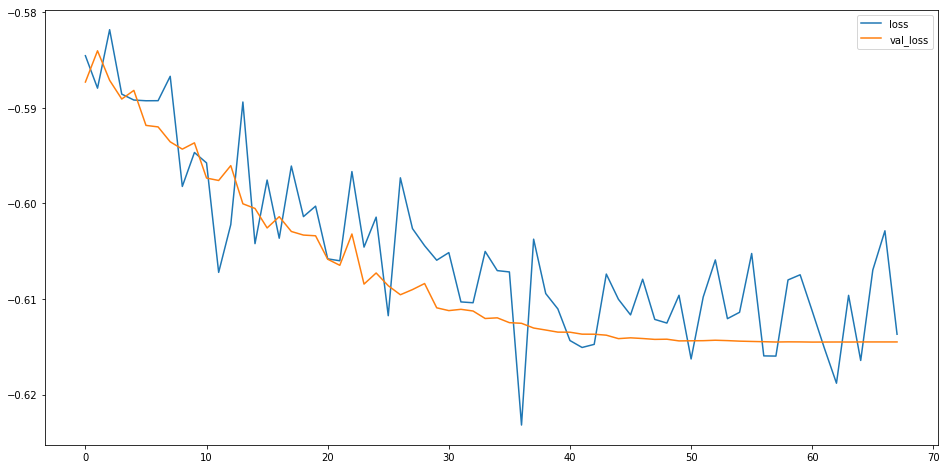

In [16]:
# 0.6145
pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))

In [17]:
def make_forecast(model):
    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    feat = yield_batch_test()
    df = model.predict_generator(feat, steps=len(votes_test.index.unique()))
    df = pd.DataFrame(df, index=votes_test.index.unique())
    df.to_csv(path / "_sub_full.csv", header=False)
    # path.rename(path.parent / f"{subdir}-{score:0.1f}")

In [18]:
make_forecast(model)